# Kanapy
## RVE of polycrystal with dispersed second phase

Notebook for Kanapy v6.1

Author: Alexander Hartmaier<br>ICAMS, Ruhr University Bochum, Germany<br>
February 2024

## 1. Import required packages

In [1]:
import kanapy as knpy
import numpy as np
import random

if int(knpy.__version__[0]) < 6 or int(knpy.__version__[2]) < 1:
    raise ModuleNotFoundError(f'Kanapy version 6.1. or higher is required. Current version is {knpy.__version__}. Please update Kanapy')
knpy.__version__


'6.1.5'

## 2. Generate polycrystal RVE
Using the `Microstructure` class of Kanapy, a microstructure object is generated, by passing the microstructure descriptors 'ms_elong' as input data to this class. The Python dictionary 'ms_elong' also contains the geometrical definition of the RVE box. After this, the method `plot_stats_init()` plots the statistical distributions that will be used for the particle simulation. Then, the method `init_RVE()` creates the simulation box and a particle set that fulfills the required size distribution within the given lower (dashed vertical line) and upper (solid vertical line) bound.  
In the second step, the particle simulation is performed by invoking the method `pack()`. To accomplish this, the particles generated in the last step are initally downscaled in size by a factor of 100 such that they can move freely through the simulation box but still fulfill the same charactistics of the size distribution with larger and smaller particles in the desired quantities. To avoid overlap of particles, collsions are considered. In this way, the particles form a realistic distribution within the space of the simulation box, as can be verified in the plot by `plot_ellipsoids()`.  
After the generation of the particle distribution of the desired volume fraction statistical distribution of particles, the method `voxelize()` generates a voxelated structure in form of a regular 3D mesh of the simulation box. Each voxel lying inside a particle will be assigned to this grain. The remaining voxels will be assigned to the grains accoriding a growth and distribution algorithm.  
The grain geometry in the voxelized 3D microstructure (representative volume element, RVE) will be analysed statistically with respect to the grain size distribution and the aspect ratio distribution. This is accomplished by running the `generate_grains()` method of the microstructure object, which performs a Delaunay tesseleation of the voxel structure by which a ployhedral hull around each grain is constructed and and analyzed with respect to grain size and aspect ratio. The results are plotted with the `plot_stats()` method.  


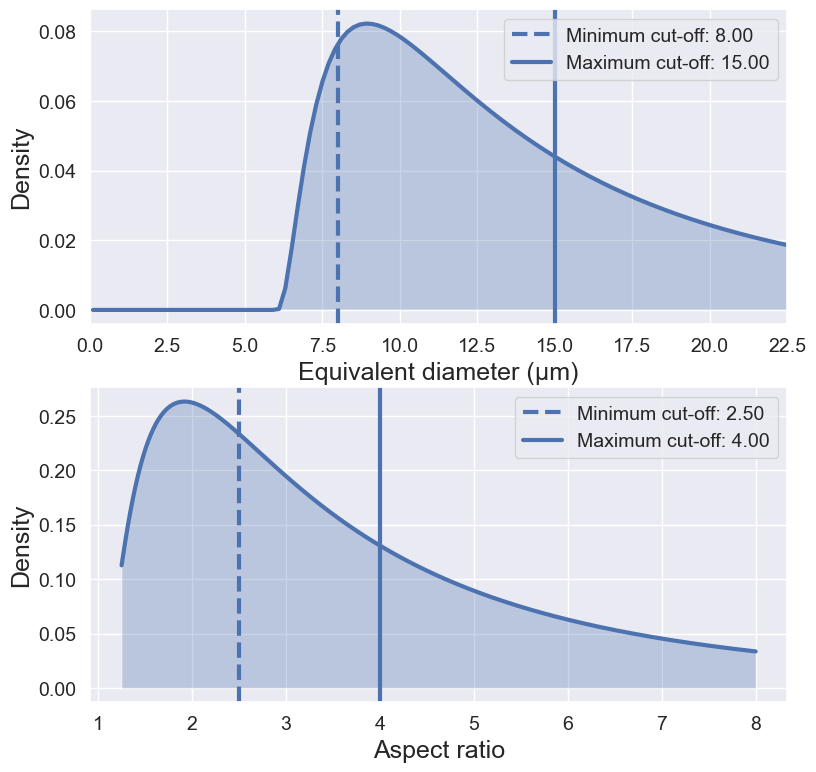

Creating an RVE based on user defined statistics
    Analyzed statistical data for phase Aluminum (0)
    Total number of particles  = 55
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (40, 40, 40) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1.3333 1.3333 1.3333](um)
    Total number of voxels     = 27000


Considered phases (volume fraction): 
0: Aluminum (100.0%)


Starting particle simulation
    Creating particles from distribution statistics
    Particle packing by growth simulation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:05<00:00, 126.65it/s]


Completed particle packing
120 overlapping particles detected after packing
Kinetic energy of particles after packing: 9.672579045585541
Initial kinetic energy: 9.672579045585541



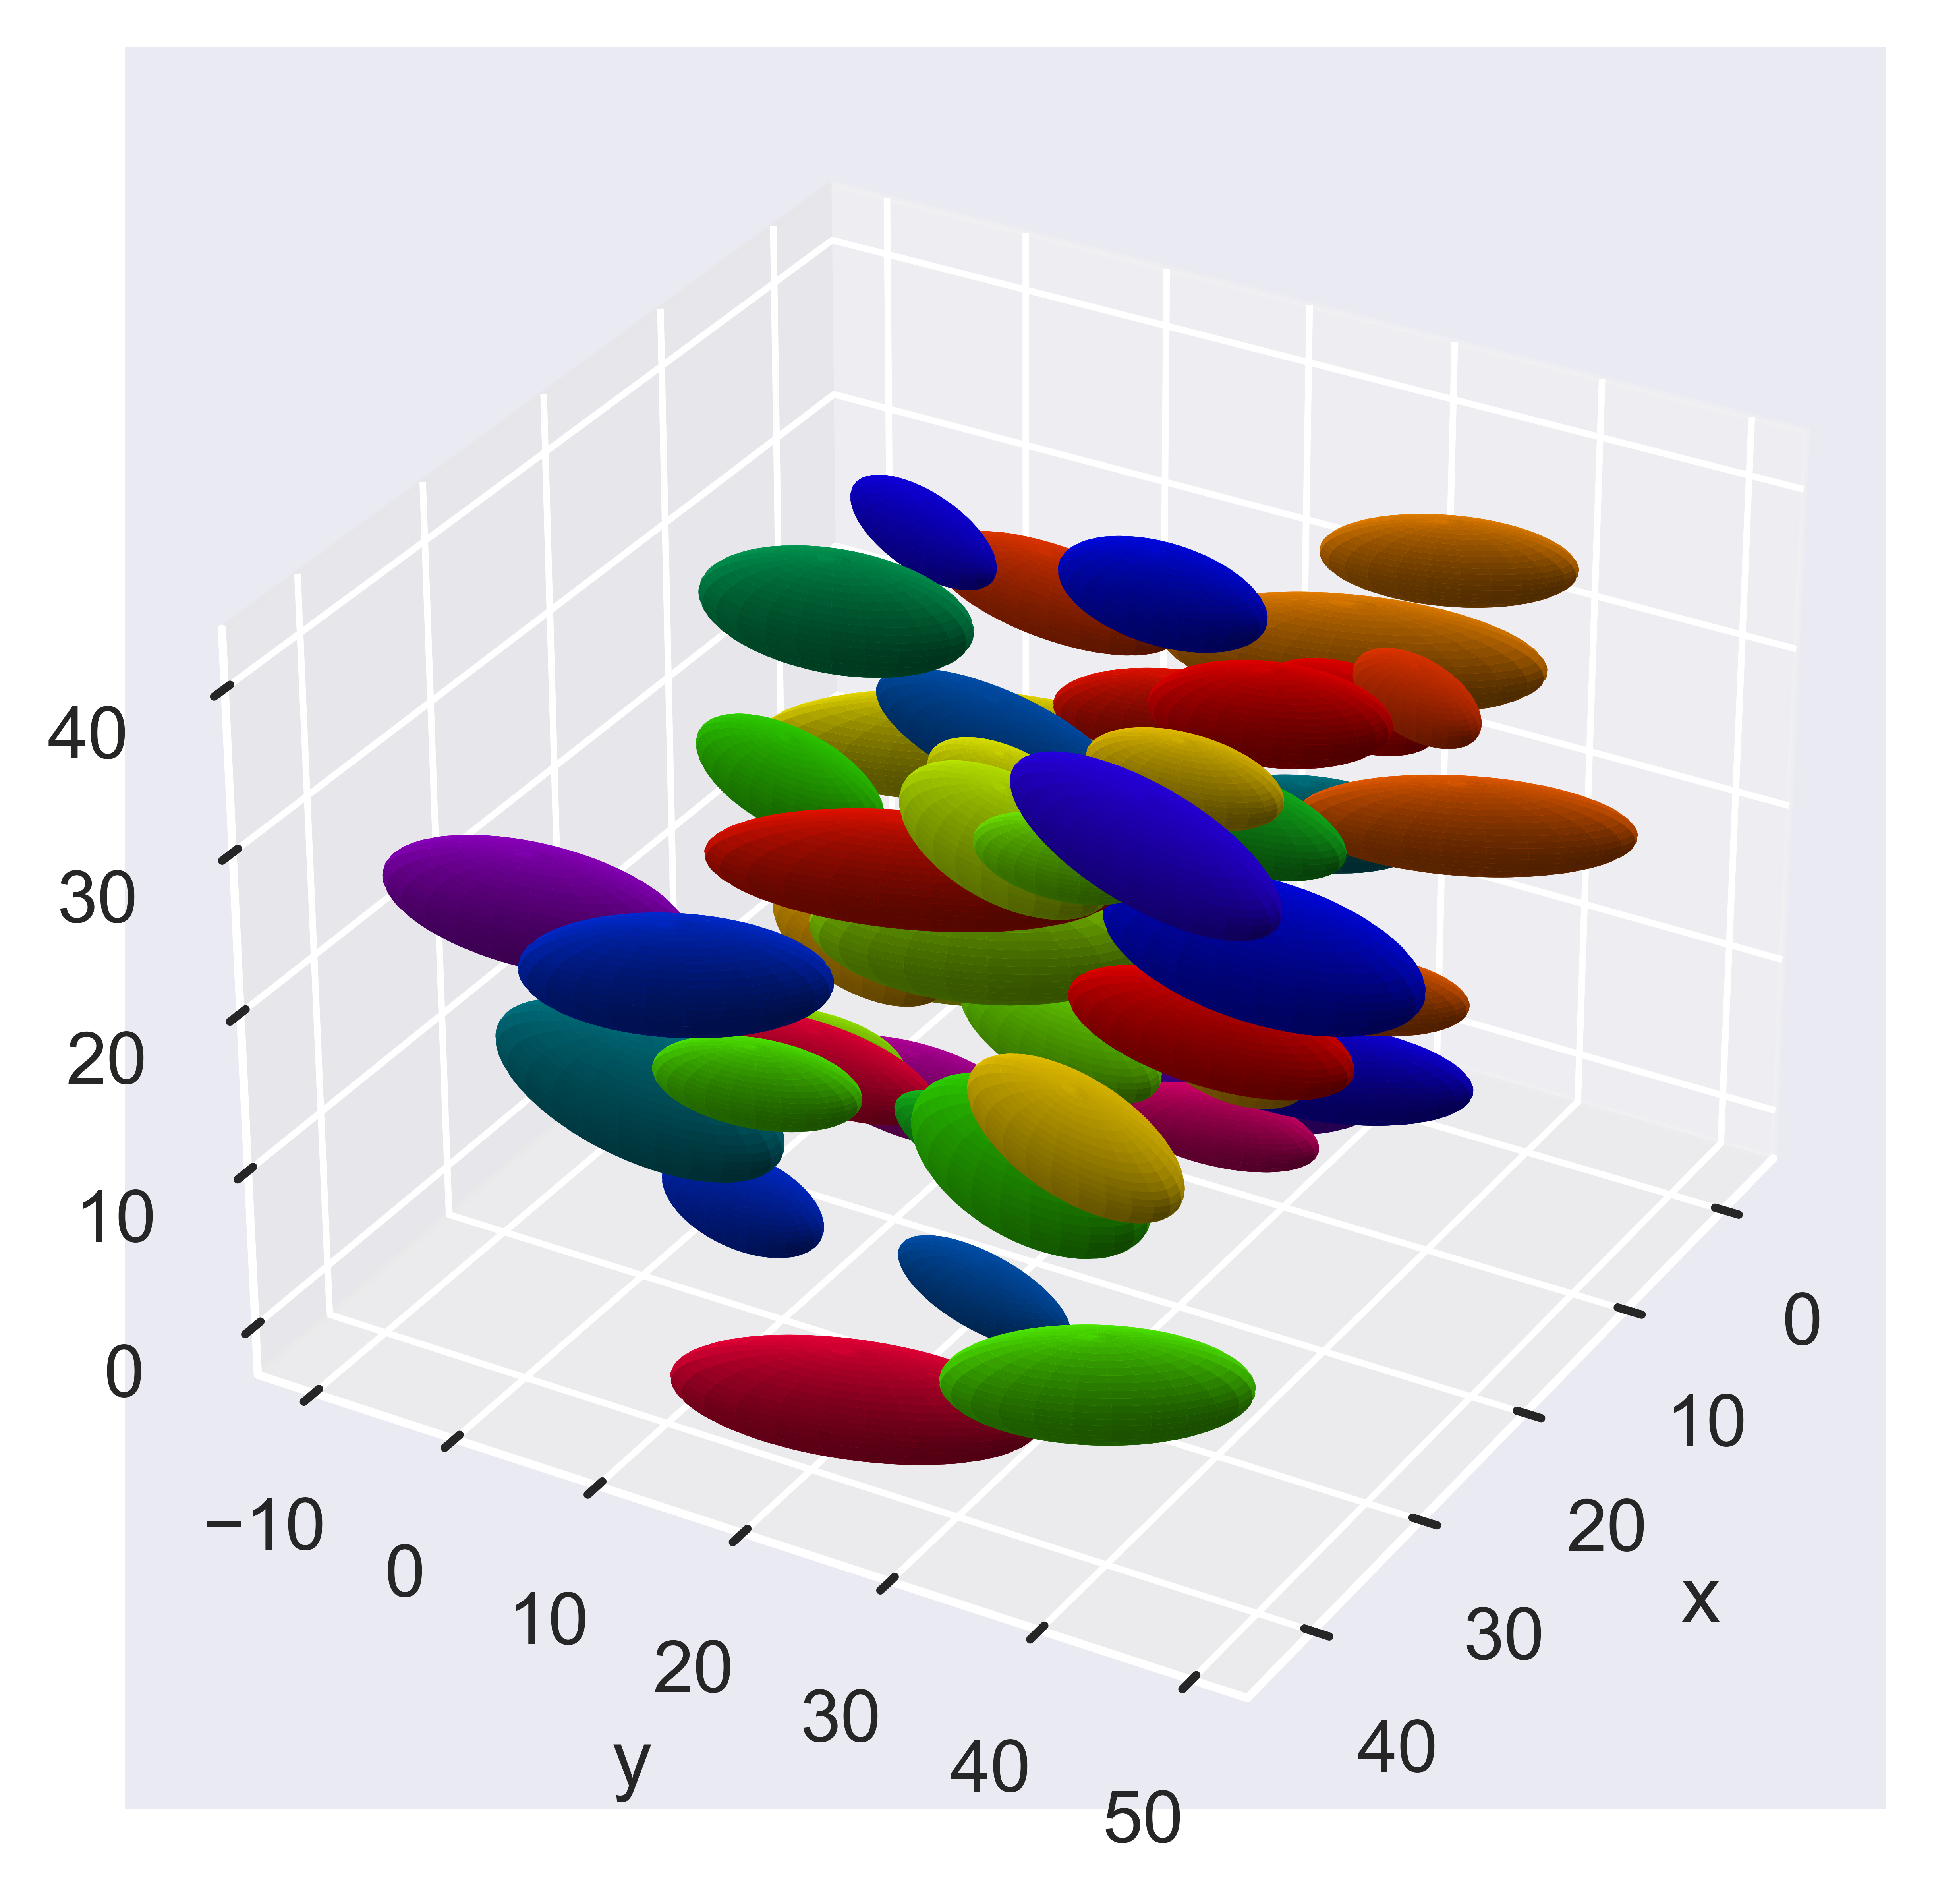

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:00<00:00, 47048694.64it/s]


Completed RVE voxelization



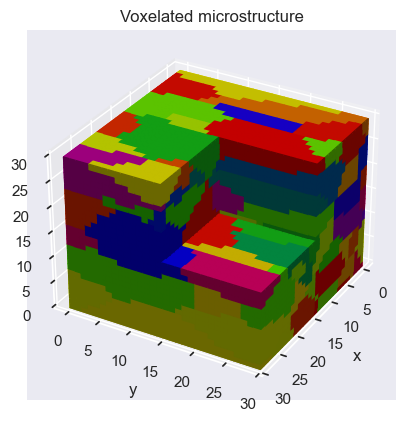


Generated Delaunay tesselation of grain vertices.
Assigning 1928 tetrahedra to grains ...


1928it [01:03, 30.49it/s]


Finished generating polyhedral hulls for grains.
Total volume of RVE: 64000 um^3
Total volume of polyhedral grains: 63998.419753086426 um^3
Mean relative error of polyhedral vs. voxel volume of individual grains: 0.141
for mean volume of grains: 1163.636 um^3.

Computing the L1-error between input and output diameter distributions.
    L1 error phase 0 between particle and grain geometries: 0.77256


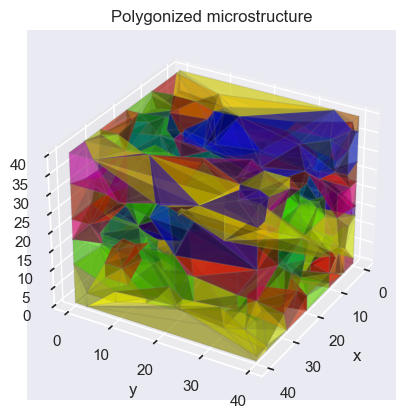

Plotting input & output statistics for phase 0


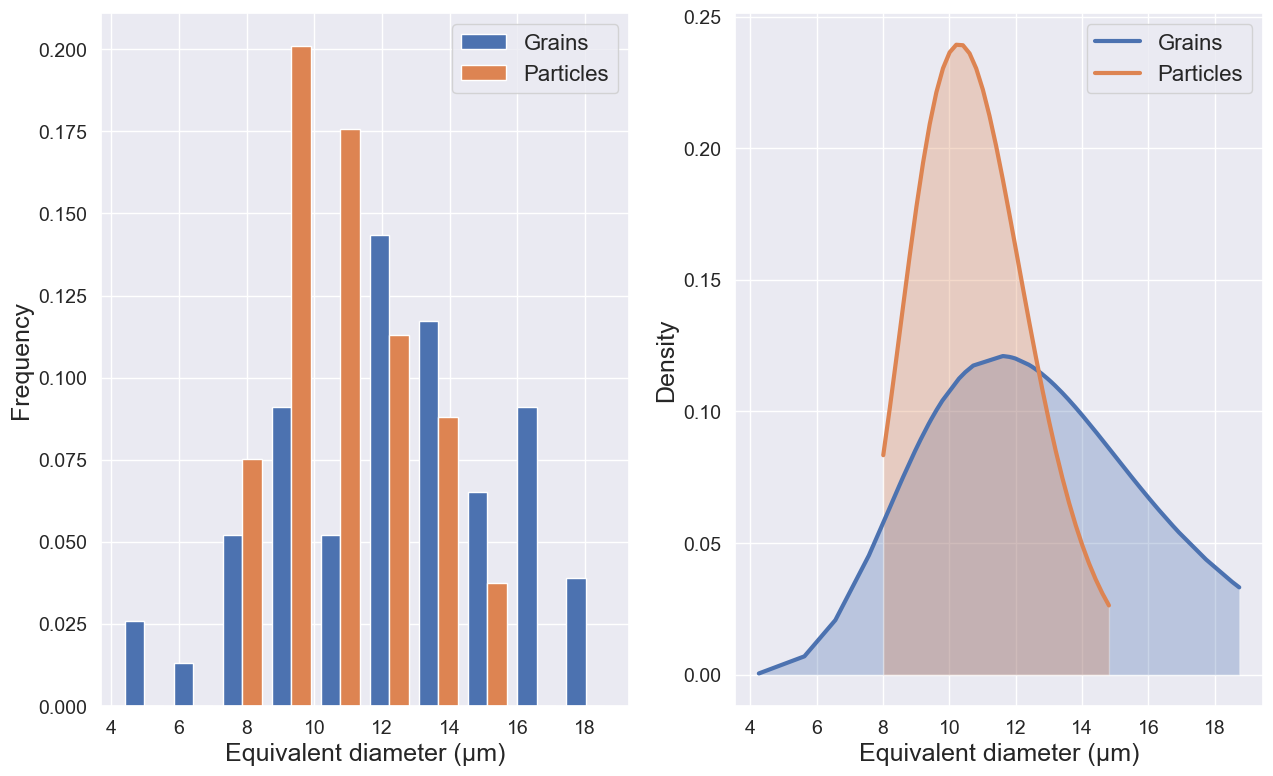

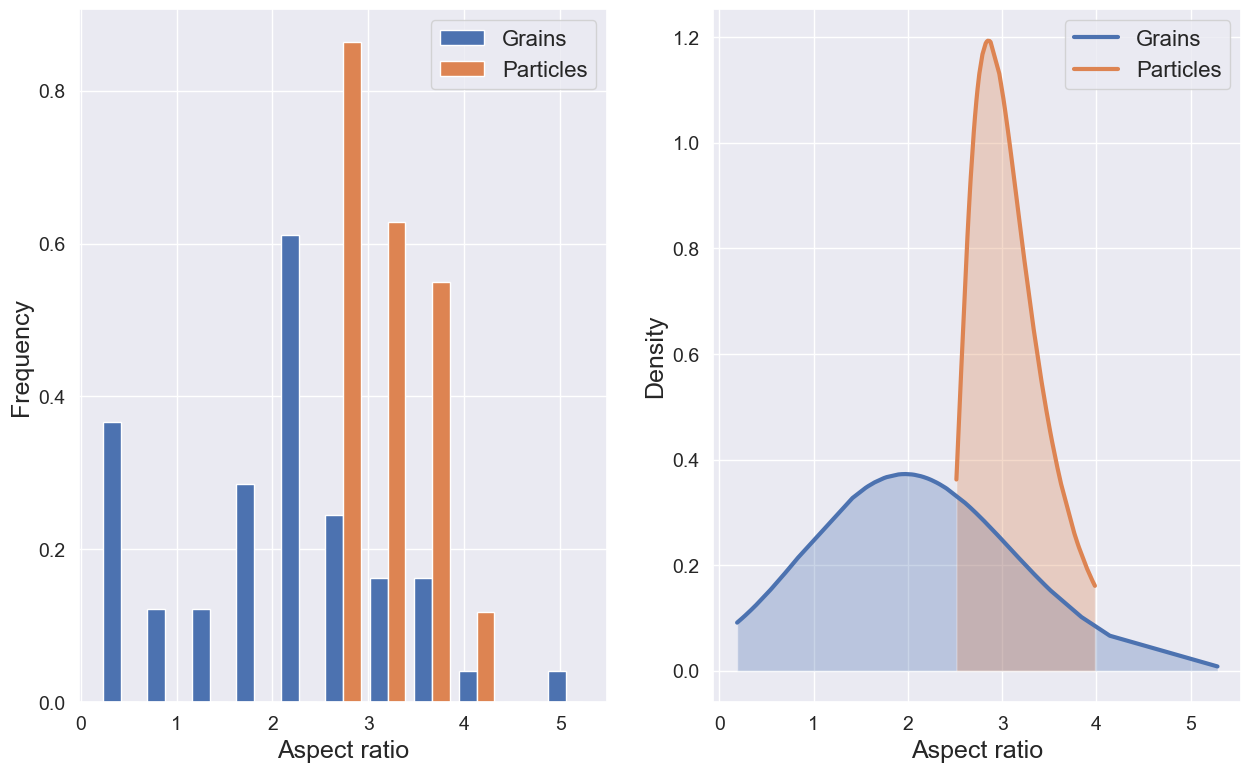

In [2]:
# Basic definitions
deg = np.pi/180.0

# RVE and microstructure parameters
matname = 'Aluminum'
Nv = 30  # number of voxels
size = 40  # size of RVE
texture = 'unimodal'
periodic = True
ms_elong = {'Grain type': 'Elongated',
          'Equivalent diameter': {'sig': 1.0, 'scale': 8.0, 'loc': 6.0, 'cutoff_min': 8.0, 'cutoff_max': 15.0},
          'Aspect ratio': {'sig':1.0, 'scale': 2.5, 'loc': 1.0, 'cutoff_min': 2.5, 'cutoff_max': 4.0},
          'Tilt angle': {'kappa': 2.*deg, 'loc': 90.*deg, "cutoff_min": 70*deg, "cutoff_max": 110*deg},
          'RVE': {'sideX': size, 'sideY':size, 'sideZ': size, 'Nx': Nv, 'Ny': Nv, 'Nz': Nv},
          'Simulation': {'periodicity': periodic, 'output_units': 'um'},
          'Phase': {'Name': matname, 'Number': 0, 'Volume fraction': 1.0}}

ms = knpy.Microstructure(descriptor=ms_elong, name=matname + '_' + texture + '_texture')
ms.plot_stats_init()  # plot initial statistics of equivalent grain diameter and aspect ratio
ms.init_RVE()  # initialize RVE including particle distribution and structured mesh
ms.pack()  # perform particle simulation to distribute grain nuclei in RVE volume
ms.plot_ellipsoids()  # plot final configuration of particles
ms.voxelize()  # assign voxels to grains according to particle configuration
ms.plot_voxels(sliced=True)  # plot voxels colored according to grain number
ms.generate_grains()  # generate a polyhedral hull around each voxelized grain
ms.plot_grains()  # plot polyhedral grains
ms.plot_stats()  # compared final grain statistics with initial parameters


## 3. Create dispersed second phase
Here, it is assumed that small particles of voxel size are distributed randomly close to the grain boundaries (GB) of the polycrystal. Such dispersed particles can be generated by using the Kanapy API to identify the voxels in the RVE that are neighbors to at least one GB. In a first step, these voxels are identifed and plotted.  
In the second step, a random sample of GB voxels are selected according to the volume fraction of the second phase, assumed to be a silicon-rich phase here. The phase information of these voxels are changed from "0" (Al) to "1" (Si). Furthermore, a new "virtual" grain with ID 0 is created that contains all Si voxels. This grain is only used to provide a set of voxels/finite elements that contain the Si-rich phase.

### 3.1. Select and plot GB voxels

Fraction of voxels at grain boundaries: 0.7662962962962963


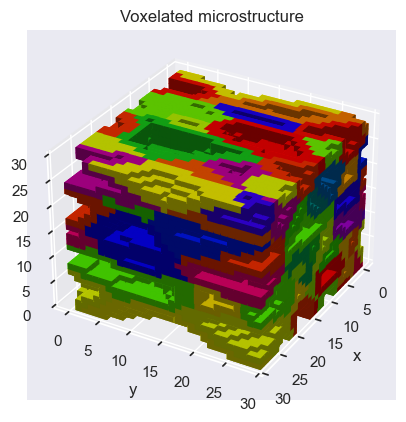

In [3]:
import numpy as np
import random
# create set with voxels of all grain boundaries
gb_vox_set = set()
# Loop over all grain boundaries in microstructure
for gba in ms.geometry['GBarea']:
    vox = set()
    gbkey = f'f{gba[0]}_{gba[1]}'  # form key to address grain boundary
    # loop over both grains forming grain boundary
    for igr in gba[0:2]:
        # loop over all voxels in grain
        for nv in ms.mesh.grain_dict[igr]:
            # loop over all nodes in grain boundary
            for node in ms.geometry['GBnodes'][gbkey]:
                if node in ms.mesh.voxel_dict[nv]:
                    # add voxel to GB set if one GB node is contained in node set of voxel
                    gb_vox_set.add(nv)

n_gbvox = len(gb_vox_set)
print(f'Fraction of voxels at grain boundaries: {n_gbvox/ms.mesh.nvox}')

# plot voxels at grain boundaries
mask = np.full(ms.mesh.dim, False, dtype=bool)
for nv in gb_vox_set:
    i, j, k = np.unravel_index(nv-1, ms.mesh.dim, order='F')
    mask[i, j, k] = True
knpy.plot_voxels_3D(ms.mesh.grains, Ngr=ms.Ngr, mask=mask)


### 3.2. Introduce second phase

Changing 4050 GB voxels to phase 1, corresponding to  15.0 vol% of dispersed particles in the microstructure.


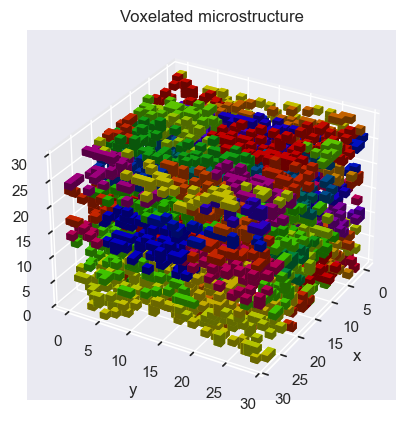

Plot of dispersed particles (green) distributed around the grain boundaries of the matrix material (red)


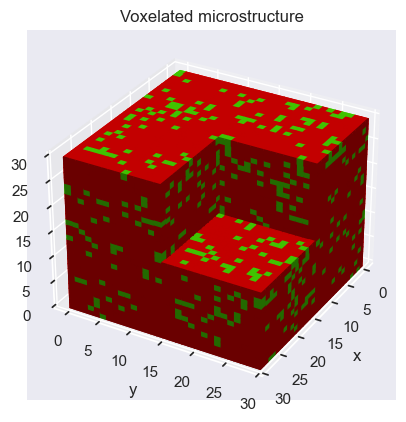

In [4]:
# select and plot subset of GB voxels
vf_Si = 0.15  # define volume fraction of dispersed particles
vf_Al = 1.0 - vf_Si  # remaining volume fraction of first phase
nfrac = int(ms.mesh.nvox * vf_Si)  # number fraction of voxels to be selected
subs = random.sample(list(gb_vox_set), nfrac)  # select random subset according to number fraction

# plot Si voxels
print(f'Changing {nfrac} GB voxels to phase 1, corresponding to {(vf_Si*100):5.1f} vol% of dispersed particles in the microstructure.')
mask = np.full(ms.mesh.dim, False, dtype=bool)
for nv in subs:
    i, j, k = np.unravel_index(nv-1, ms.mesh.dim, order='F')
    mask[i, j, k] = True  # mask for plotting
knpy.plot_voxels_3D(ms.mesh.grains, Ngr=ms.Ngr, mask=mask)

# Create new phase in microstructure object, assign new phase and new virtual grain to selected voxels
ms.nphases = 2  # increase number os phases in microstructure object
ms.rve.phase_names.append('Silicon')  # add phase name
ms.rve.phase_vf = [vf_Al, vf_Si]  # update volume fractions
ms.mesh.grain_phase_dict[0] = 1  # create new grain with id 0 for phase 1 (Silicon)
ms.mesh.grain_dict[0] = []  # initialize voxel list for new grain
# change phase for selected voxels and move from original grain to grain 0
for nv in subs:
    i, j, k = np.unravel_index(nv-1, ms.mesh.dim, order='F')
    ms.mesh.phases[i, j, k] = 1  # change phase for voxels in phase grid
    ms.mesh.grains[i, j, k] = 0  # assign voxels to virtual grain "0" in grain grid
    ms.mesh.grain_dict[0].append(nv)  # add voxel to list for grain 0
    # remove voxel from its original grain
    for igr, lvox in ms.mesh.grain_dict.items():
        if nv in lvox:
            ms.mesh.grain_dict[igr].remove(nv)
            break

print('Plot of dispersed particles (green) distributed around the grain boundaries of the matrix material (red)')
ms.plot_voxels(dual_phase=True)

## 4. Calculate grain orientations according to given texture
The texture module of Kanapy is invoked to run the MTEX functions that create grain orientation according to a given texture definition. The values for ang and omega corrspond to a Goss texture. See notebook on RVE generation ([generate_rve.ipynb](generate_rve.ipynb)) for details.

In [5]:
# generate and assign grains orientations
# Note that angles are given in degrees
ms.generate_orientations(texture, ang=[0, 45, 0], omega=7.5)

I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  ....Warning: "/Volumes/Extern/Codes/kanapy/libs/mtex/extern/nfft_openMP" not found in path.
> In rmpath>doRemoveFromPath (line 102)
In rmpath (line 59)
In check_installation (line 7)
In startup_mtex (line 79)
In startup (line 9)

********************************************************************************

********************************************************************************
 done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 

time =

    9.4692



## 5. Export voxelated structure as Abaqus input deck
The geometrical information of the RVE is exported as Abaqus input file with the ending "_geom.inp" by the method `write_abq()`. This input deck defines a finite element for each voxel (selected by option: 'v'). The element type is set to 'C3D8', representing 3D hexagonal element with 8 nodes, i.e., linear shape function. Furthermore, for each Al grain a set of elements is defined and assigned to a user defined material with the name "GRAIN{grain_id}_MAT". The finite elements representing the Si-rich phase will be assigned to the material "PHASE1_MAT".  
By the same method, the information on the grain orientations is exported as Abaqus input file with the ending "_mat.inp". This file contains the information on the material number to be used in the ICAMS Crystal Plasticity UMAT and the Euler angles for each Al grain, identified by the name "GRAIN{grain_id}_MAT". The _geom.inp file contains an *INCLUDE command to read the material definitions for the Al polycrystal in the _mat.inp file. Furthermore, a plain material definition for PHASE1_MAT is contained, where the material properties of that phase need to be added later.


In [6]:
# write Abaqus input file for voxelated structure
ms.write_abq(nodes='v', file='AlSi_RVE_geom.inp', ialloy=1)


Writing RVE as ABAQUS file "./AlSi_RVE_geom.inp"
Using brick element type C3D8.
---->DONE!



'./AlSi_RVE_geom.inp'

## 6. Safe voxelized structure (re-entry point upon restart)
The voxel structure including the information on grain orientation and phases achived at this point can be stored as JSON file that contains all information on phase, grain and voxel level. This file can be used to import the voxel structure into kanapy with `knpy.import_voxels(file)`.


In [7]:
# Save Kanapy microstructure as voxel file
ms.write_voxels(file='AlSi_RVE_voxel.json', script_name='dispersed_phase.ipynb', mesh=False, system=False)

Writing voxel information of microstructure to ./AlSi_RVE_voxel.json.


Creating an RVE from voxel input
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (40, 40, 40) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1.3333 1.3333 1.3333](um)
    Total number of voxels     = 27000


Considered phases (volume fraction): 
0: Aluminum (85.0%)
1: Silicon (15.0%)


    Generating voxels inside RVE

 Voxel structure imported.



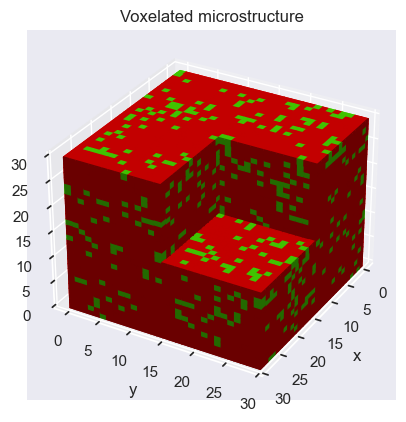

In [8]:
# Read Kanapy microstructure from voxel file
ms2 = knpy.import_voxels('AlSi_RVE_voxel.json')
ms2.plot_voxels(sliced=True, dual_phase=True)